# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Исходные данные

Загрузим исходный датасет. Посмотрим его структуру, пропуски, дубликаты. Построим гистрограммы для всех числовых колонок, чтобы оценить выбросы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
try: 
    data = pd.read_csv('d:/practicum/3sprint/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
   

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.duplicated().sum()

0

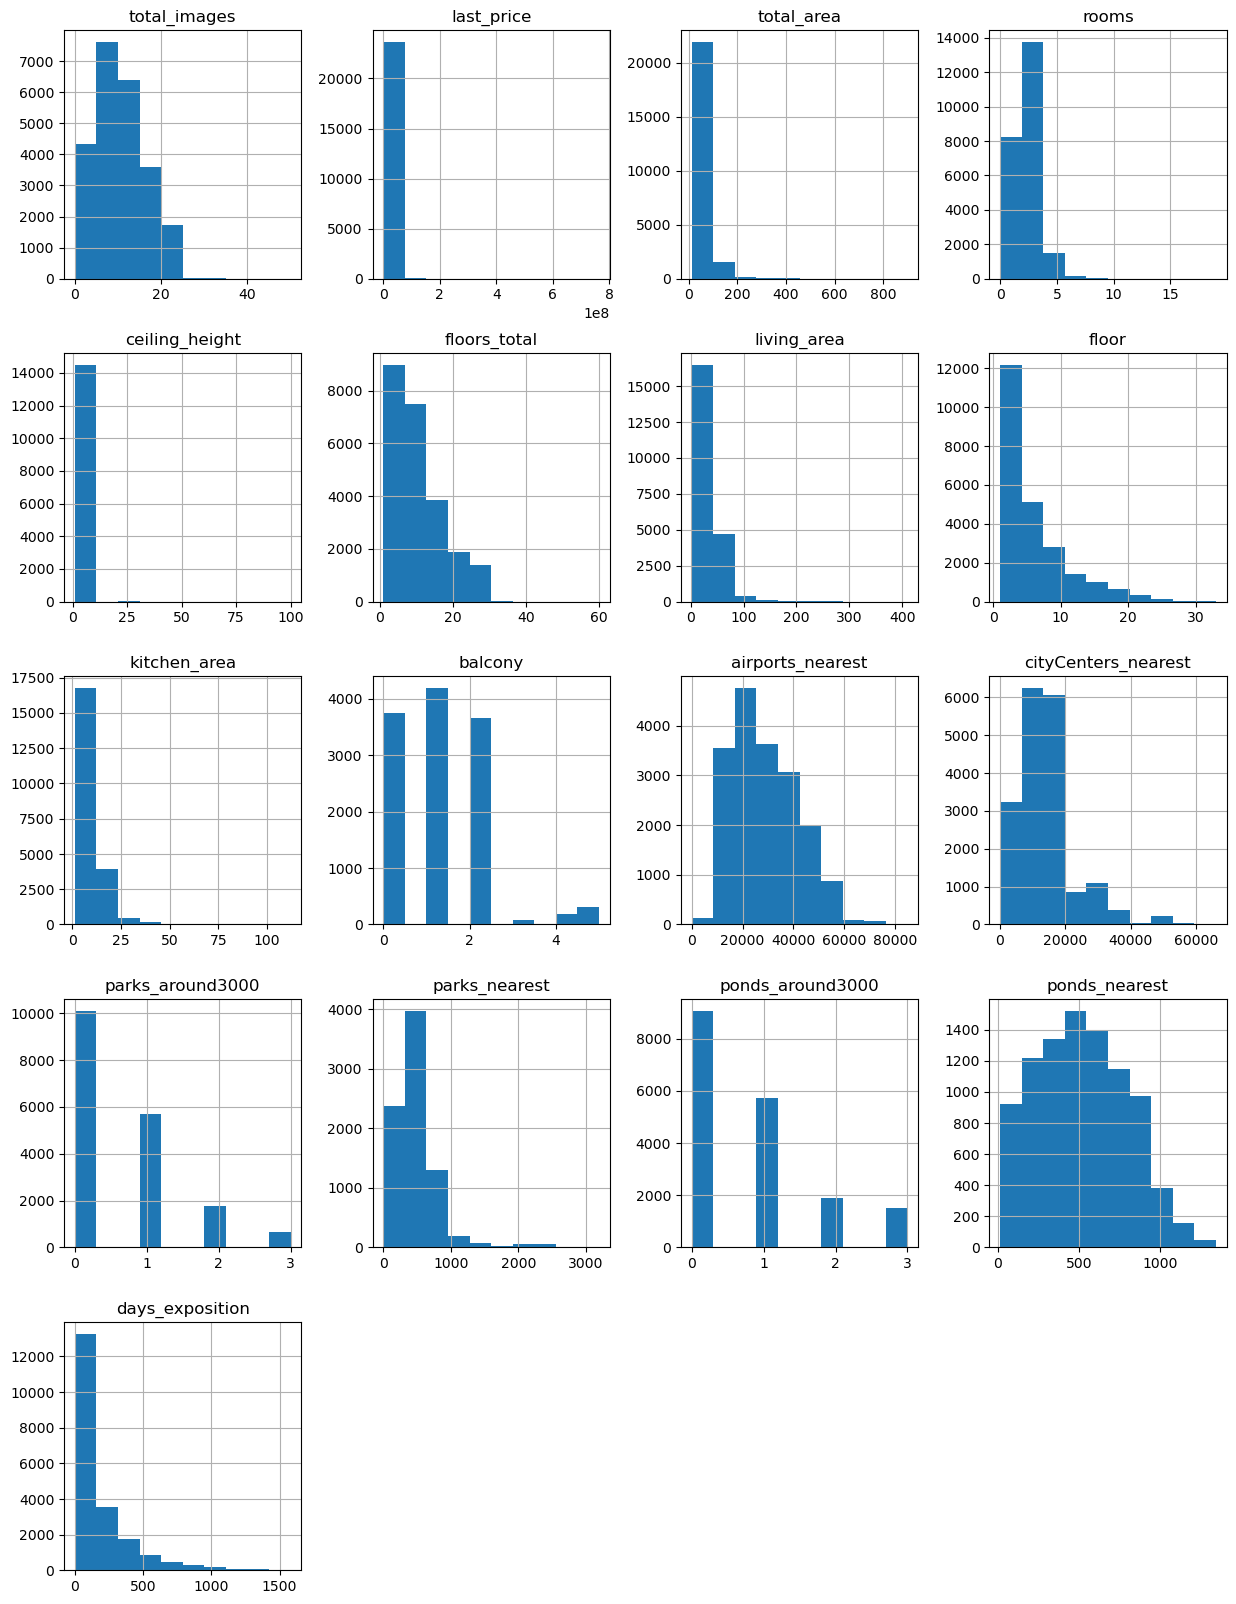

In [6]:
data.hist(figsize=(15, 20));

In [7]:
datarows = len(data)

In [8]:
dddd = pd.DataFrame(np.random.randn(3, 1), columns=['col1'])

In [9]:
dddd['ft'] = ['a', 'b', 'c']

In [10]:
dddd.head(10)

,col1,ft
0,0.443817,a
1,2.217483,b
2,-0.280839,c


<u><b>Промежуточный вывод</b></u> 

- База данных содержит 23699 строк, 22 колонки
- в 12 колонках есть пропуски: населеный пункт, площади общая / жилая / кухни, балконы, потолки, этажи, парки / водоемы / аэропорты рядом
- дубилкатов нет
- Выбросы могут быть в 7 колонках: цена, площади, кол-во комнат, высота потолков, этажность, кол-во балконов, растояниях до парков / водоемов


## Предобработка данных

Проанализаруем пропуски и типы данных в отдельных колонках исходного датасета
Где это возможно - заполним пропуски, найдем неявные дубликаты и исправим типы данных для дальнейшешго анализа

### Пропуски в данных

В 12 колонках есть пропуски: 
 - airports_nearest
 - balcony 
 - ceiling_height
 - cityCenters_nearest  
 - days_exposition 
 - floors_total
 - is_apartment
 - kitchen_area 
 - living_area 
 - locality_name 
 - parks_around3000 
 - parks_nearest
 - ponds_around3000
 - ponds_nearest   

Пропуски обусловлены либо "человеческим фактором" при заполнении объявлений, либо алгоритмом Яндекса. Скоре всего, пропуски в колонках balcony, ceiling_height, floors_total, is_apartment, living_area, locality_name появились при заполнении объявлений человеком - автор либо не знает этих данных, либо не сообразил, что надо поставить. В остальных колонках пропуски обусловлены работой алгоритма, в частности, при незаполненой локации нельзя вычислить и расстояние до парков/аэропортов количество центров и парков.


Без дополнительных исследований заменить пропуски можно в полях balcony, is_apartment и locality_name

#### Пропуски в колонке balcony

Скорее всего, пропуск в этой колонке означает, что банконов нет, поэтому заполним пропуски 0

In [11]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [12]:
data['balcony'] = data['balcony'].fillna(0)

Проверяем количество пропусков

In [13]:
data['balcony'].isna().sum()

0

#### Пропуски в колонке is_apartment

Cкорее всего, пропуски в этой колонке означают, что это не апартаменты

In [14]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Тип поля boolean, значения False / True, то есть заполняем пропуски False

In [15]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Проверяем количество пропусков

In [16]:
data['is_apartment'].isna().sum()

0

#### Пропуски в колонке locality_name

Пропуски в колонке с названиями населенных пунктов, скорее всего, связаны с тем, что авторы объявлений их не указали. Заполнить такие пропусти можно строчкой "Не известно", чтобы потом можно было проводить различные операции с данынми.

In [17]:
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

#### Пропуски в колонке floors_total

В колонке общее количество этажей также есть пропуски. Скорее всего, они связаны с тем, что авторы объявлений не указали этажность своего дома. Корректно заполнить такие пропуски нельзя. Варианты - оставить NaN, либо заполнить заведомо некорректным значением, но нужного типа данных, чтобы потом можно было проводить различные операции с колонкой. Например, "0", "-999".

Так как дальше эту колонку использовать не предполагается - оставим как есть.

In [18]:
data['floors_total'].isna().sum()

86

### Тип данных колонок

Проверим типы данных в колоноках

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

6 колонок имют неподходящий тип данных
 - first_day_exposition - тип object, должен быть datetime 
 - balcony, days_exposition, floors_total, parks_around3000, ponds_around3000 - тип float, должен быть int
 
На данном этапе исправить можно только first_day_exposition и balcony. В остальных колонках есть пропуски, заполнение которых требует дополнительного исследования.

In [20]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['balcony'] = data['balcony'].astype('int')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

<u><b>Промежуточный вывод</b></u> 

На данном этапе мы заполнили пропуски в колонках, где это можно сделать без доплнительного анализа, а также исправили типы данных в колонках, где нет пропусков

### Неявные дубликаты в колонке - locality_name

Выведем уникальные значения locality_name, отсортировав их 

In [22]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Неизвестно',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровс

Перед некоторым названиями написаны типы населенных пунктов - "деревня", "поселок", "станция" и тд. их надо убрать

In [23]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['^[а-я ]*',
             ], '', regex=True)
) 

In [24]:
sorted(data['locality_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпоселок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Иссад',
 'Калитино',

data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['деревня ', \
              'поселок ', \
              'городского типа ', \
              'коттеджный ', 'городской ', \
              'село ', \
              'садовое товарищество ', \
              'садоводческое некоммерческое товарищество ', \
              'при железнодорожной станции ', \
              'станции ', \
              'имени ',
             ], '', regex=True)
) 

In [25]:
sorted(data['locality_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпоселок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Иссад',
 'Калитино',

Проверим количество полных дубликатов строк в базе

In [26]:
data.duplicated().sum()

0

### Добавим в датасет колонки, которые нам потребуются для дальнейшего анализа

Добавм колонку price_1m - цена одного квадратного метра

In [27]:
data['price_1m'] = round(data['last_price'] / data['total_area'], 2)

Добавм слотбцы week_day, month, yaer - день недели, месяц и год публикации объявления соотственно

In [28]:
data['week_day'] = pd.DatetimeIndex(data['first_day_exposition']).day_of_week
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

Добавм слотбец to_cityCenters - растояние до центра в километрах

In [29]:
data['to_cityсenter'] = round(data['cityCenters_nearest'] / 1000, 0)

Добавм слотбец floor_type - этаж "первый", "последний", "другой"

Последний ли этаж определить невозможно, если нет данных сколько всего этажей в доме или явно не указан первый этаж. всего таких 83 объявления. Обозначим их как "другой"

In [30]:
data[data['floor'] != 1]['floors_total'].isna().sum()

83

In [31]:
data['floor_type'] = 'другой'
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'
data.groupby('floor_type')['floor_type'].count()

floor_type
другой       17446
первый        2892
последний     3361
Name: floor_type, dtype: int64

In [32]:
data['floor_type'].isna().sum()

0

In [33]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1m,week_day,month,year,to_cityсenter,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,16.0,другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,19.0,первый
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,14.0,другой
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,7.0,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,8.0,другой


# Проведите исследовательский анализ данных

## Исследовательский анализ данных

### Общая площадь (колонка total_area)

In [34]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

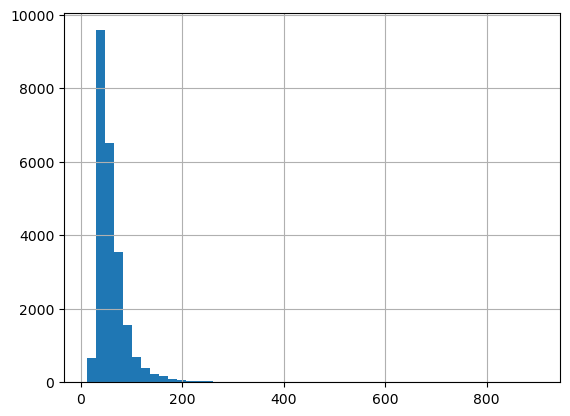

In [35]:
data['total_area'].hist(bins=50);

Из гистограммы можно сделать вывод, что основаная масса продаваемых квартир имеет площадь меньше 200 кв. метров. При этом и подозрительно маленькие квартиры.

 Оценим сколько квартир в базе имеют площадь больше 400, 300, 200, 100 кв.м

In [36]:
for d in [400, 300, 200, 100]:
    c = data[data['total_area'] > d]['total_area'].count()
    print('Квартир больше', d, 'квм. -', c, '-', round(100 * c / datarows,2),'%')

Квартир больше 400 квм. - 23 - 0.1 %
Квартир больше 300 квм. - 61 - 0.26 %
Квартир больше 200 квм. - 227 - 0.96 %
Квартир больше 100 квм. - 1836 - 7.75 %


In [37]:
for d in [15, 20, 25, 30]:
    c = data.query('total_area < @d')['total_area'].count()
    print('Квартир меньше', d, 'квм. -', c, '-', round(100 * c / datarows,2),'%')

Квартир меньше 15 квм. - 6 - 0.03 %
Квартир меньше 20 квм. - 27 - 0.11 %
Квартир меньше 25 квм. - 190 - 0.8 %
Квартир меньше 30 квм. - 693 - 2.92 %


Меньше 1% квартир имею площадь меньше 200 квм. - их можно отбросить. Как и квартиры менее 25 квадратных метров.

In [38]:
data = data[(data['total_area'] < 200) & (data['total_area'] > 25)]

Снова посмотроим гистограмму total_area

In [39]:
data['total_area'].describe()

count    23233.000000
mean        58.515024
std         26.358089
min         25.070000
25%         40.100000
50%         52.000000
75%         69.000000
max        199.200000
Name: total_area, dtype: float64

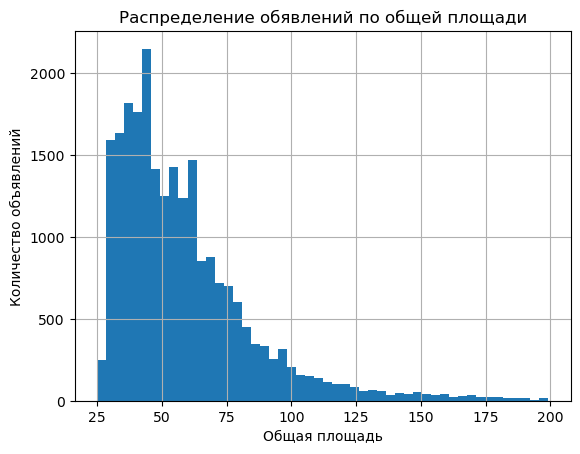

In [40]:
data['total_area'].hist(bins=50);
plt.title('Распределение обявлений по общей площади')
plt.ylabel('Количество объявлений')
plt.xlabel('Общая площадь')
plt.show()

<u><b>Промежуточный вывод</b></u> 

Из датасета удалили квартиры с подозрительно большими и маленькими площадями. В итоге статистические хактеристики улучшились - среднее значение стало значительно ближе к медиане. Распределение площади квартир стало ближе к нормальному.

### Жилая площадь и площадь кухни (колонки living_area и kitchen_area)

Общая площадь помещения, жилая площадь и площадь кухни должны быть взаимосвязаны. Если это так, то используя колонку total_area, которая в исходном датасете не имеет пропусков, можно заполнить пропуски на основе общей площади.

In [41]:
data[['total_area', 'living_area', 'kitchen_area']].corr()['total_area']

total_area      1.000000
living_area     0.923341
kitchen_area    0.563273
Name: total_area, dtype: float64

Первычный анализ показывает сильную кореляцию общей площади с жилой площадью. С площадью кухни корреляция меньше 0,5, возможно это обусловлено выбросами.

Статистические метрики колонок living_area, kitchen_area

In [42]:
data[['living_area', 'kitchen_area']].describe().T

,count,mean,std,min,25%,50%,75%,max
living_area,21402.0,33.402150,17.339391,2.0,18.7,30.0,42.0,164.7
kitchen_area,21169.0,10.396624,5.367631,1.3,7.0,9.0,12.0,93.2


В колонках living_area, kitchen_area порядка 2000 пропусков в каждой, в 1500 строчках пропущены оба значения

In [43]:
data['living_area'].isna().sum()

1831

In [44]:
data['kitchen_area'].isna().sum()

2064

In [45]:
data[data['kitchen_area'].isna() & data['living_area'].isna()]['total_area'].count()

1401

Заполним пока пропуски -1, чтобы можно было их обрабатывать

In [46]:
data['kitchen_area'] = data['kitchen_area'].fillna(-1);
data['living_area'] = data['living_area'].fillna(-1);

Проверим, есть ли в данные в которых жилая площадь, площадь кухни больше или равна общей, чего не должно быть

In [47]:
data[data['total_area'] <= (data['living_area'] + data['kitchen_area'])]['total_area'].count()

125

Есть такие квартиры - отбрасываем. 

In [48]:
data = data[data['total_area'] > (data['living_area'] + data['kitchen_area'])]

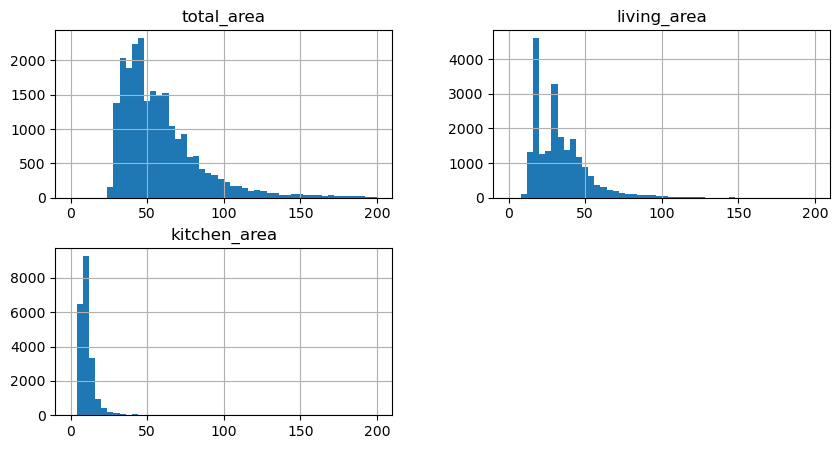

In [49]:
data[['total_area', 'living_area', 'kitchen_area']].hist(bins=50, figsize=(10,5), range=(0, 200));

Согластно нормативам, минмальная жилая площадь составялет 18 кв. метров. Но это касается новостроек.
В старых домах вполне может встречаться и меньшая площадь. В интернете встречается упоминание квартиры с минимальной жилой площадью в 13 кв. метров. Для кухни минимальные значение - 5 кв.м. Посмотрим сколько в наших данных квартир с параметрами меньше 13 и 5 соотвественно.

In [50]:
data.query('living_area < 13 and living_area != -1')['living_area'].count()

168

In [51]:
data[(data['kitchen_area'] < 5)  & (data['living_area'] != -1)]['kitchen_area'].count()

748

Удалим их из исходного датасета

In [52]:
data = data.query('living_area >= 13 or living_area == -1')
data = data[(data['kitchen_area'] >= 5) | (data['kitchen_area'] == -1)]

Добавим столбцы соотношения жилой площади и площади кухни к общей площади

In [53]:
data['t_k'] = data['kitchen_area'] / data['total_area']
data['t_l'] = data['living_area'] / data['total_area']

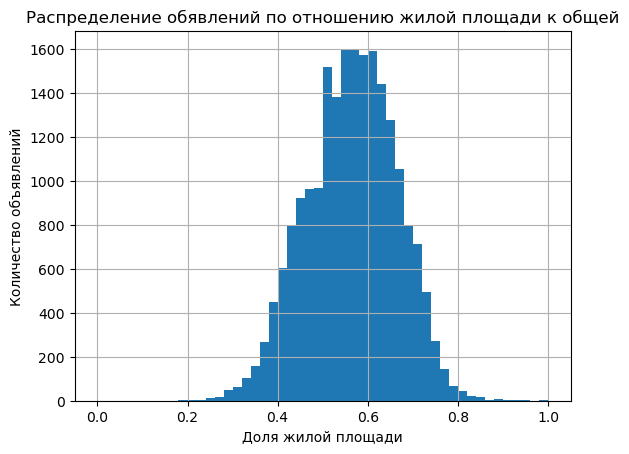

In [54]:
data['t_l'].hist(bins=50, range=(0, 1));
plt.title('Распределение обявлений по отношению жилой площади к общей')
plt.ylabel('Количество объявлений')
plt.xlabel('Доля жилой площади')
plt.show()

Соотношение жилой площади к общей имеет почти симметричное нормальное распределение

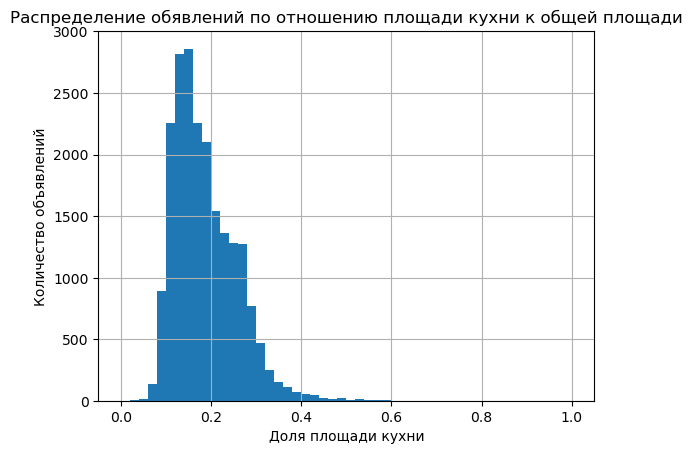

In [55]:
data['t_k'].hist(bins=50, range=(0, 1));
plt.title('Распределение обявлений по отношению площади кухни к общей площади')
plt.ylabel('Количество объявлений')
plt.xlabel('Доля площади кухни')
plt.show()

Соотношение площади кухни к общей площади также близко к виду нормального распределения

In [56]:
data[data['t_k'] > 0.4]['t_k'].count()
for d in [0.5, 0.4, 0.3, 0.2]:
    c = data[data['t_k'] > d]['t_k'].count()
    print('Квартир с отношением кухни к общей пл.', d, '-', c, '-', round(100 * c / datarows,2),'%')

Квартир с отношением кухни к общей пл. 0.5 - 30 - 0.13 %
Квартир с отношением кухни к общей пл. 0.4 - 186 - 0.78 %
Квартир с отношением кухни к общей пл. 0.3 - 1220 - 5.15 %
Квартир с отношением кухни к общей пл. 0.2 - 7277 - 30.71 %


Добавим столбцы соотношения жилой площади и площади кухни к общей площади

In [57]:
data['t_k'] = data['kitchen_area'] / data['total_area']
data['t_l'] = data['living_area'] / data['total_area']

Менее 1% квартир имеют подозрительно большие кухни - больше 40% от общей площади. Их можно откинуть.

In [58]:
data = data[(data['t_k'] <= 0.4) | (data['kitchen_area'] == -1)]

Определим статистические метрики значения отношения обей площади к жилой площади и площади кухни

In [59]:
data[['t_k','t_l']].describe().T

,count,mean,std,min,25%,50%,75%,max
t_k,22668.0,0.165371,0.085027,-0.039888,0.122172,0.162162,0.221336,0.400000
t_l,22668.0,0.518590,0.184737,-0.039761,0.471598,0.557185,0.629193,0.989315


Медиана и среднее отношение общей площади к площади кухни почти совпало - 0.16
Медиана и среднее отношения общей площади к жилой площади тоже близко - 0.51-0.55
Заменим пропуски в столбцах living_area и kitchen_area, умножив общую площадь на эти коэффециенты.

In [60]:
data['living_area_new'] = data['living_area']
data.loc[data['living_area_new'] == -1, 'living_area_new'] = data['total_area'] * 0.55
data['kitchen_area_new'] = data['kitchen_area']
data.loc[data['kitchen_area_new'] == -1, 'kitchen_area_new'] = data['total_area'] * 0.16;

Еще раз построим гистограммы площадей - общей, жилой и кухни

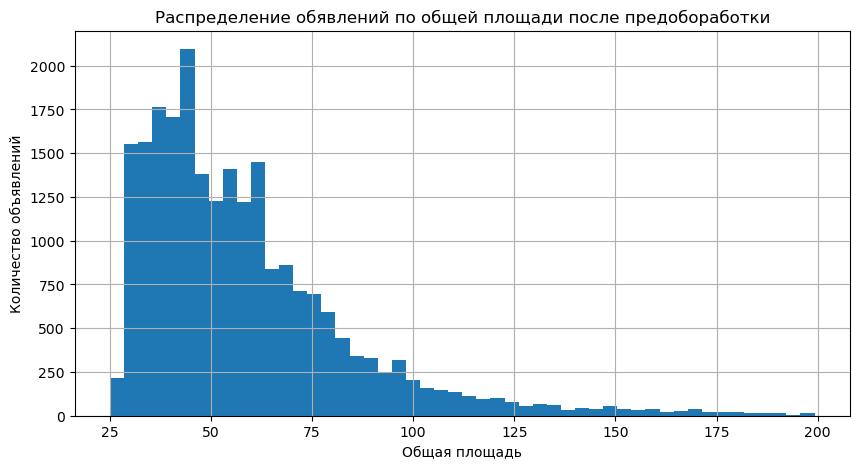

In [61]:
data['total_area'].hist(bins=50, figsize=(10,5));
plt.title('Распределение обявлений по общей площади после предобоработки')
plt.ylabel('Количество объявлений')
plt.xlabel('Общая площадь')
plt.show()

Распределение обявлений по площади кухни до и после предобоработки


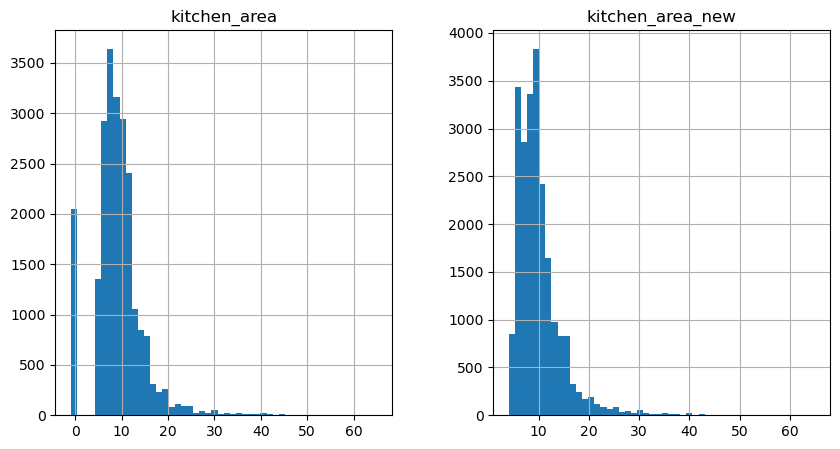

In [62]:
data[['kitchen_area', 'kitchen_area_new']].hist(bins=50, figsize=(10,5));
print('Распределение обявлений по площади кухни до и после предобоработки')

Распределение обявлений по жилой площади до и после предобоработки


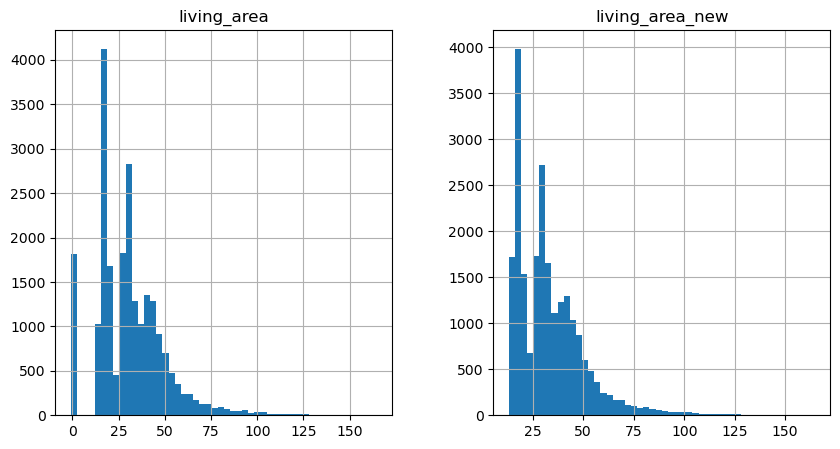

In [63]:
data[['living_area', 'living_area_new']].hist(bins=50, figsize=(10,5));
print('Распределение обявлений по жилой площади до и после предобоработки')

Пики в диаграмме жилой площади, видимо, обусловлены типичными площадями по числу комнат

<u><b>Промежуточный вывод</b></u> 

Выявленные зависимости плошади кухни, жилой площади и общей площади позволили заполнить пропуски, а не отбрасывать данные  порядка 2000 строк.

### Высота потолков (колонка ceiling_height)

По действующим нормативам, минимальаня высота потолка - 2,5 метра, верхней границы нет. В рамках разумного, и учитывая, что Санкт-Петербург старинный город, потолки должны быть не больше 4 метров и не меньше 2.

Первая оценка данных по высотам потолка

In [64]:
data['ceiling_height'].describe()

count    13916.000000
mean         2.751985
std          0.915989
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

Высота потолка больше 10 может быть ошибкой заполнения заявления, когда заявитель не поствил точку. Посчитаем, сколько таких строк

In [65]:
data[data['ceiling_height'] > 10]['ceiling_height'].count()

21

Заменим данные в ним, поделив на 10

In [66]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data['ceiling_height'] / 10

Снова оценим данные

In [67]:
data['ceiling_height'].describe()

count    13916.000000
mean         2.718490
std          0.280623
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

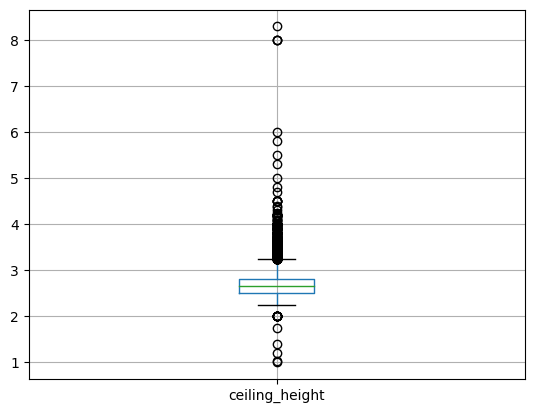

In [68]:
data.boxplot(column='ceiling_height');

Высота полотка меньше 2 и больше 3,25 - явные выброса данных.

In [69]:
data[data['ceiling_height'] < 2]['ceiling_height'].count()

5

In [70]:
data[data['ceiling_height'] > 3.25]['ceiling_height'].count()

625

Расчитаем медиану высоты потолков, без значений, которые попадают в выбросы

In [71]:
data[(data['ceiling_height'] > 2) & (data['ceiling_height'] < 3.5)]['ceiling_height'].median()

2.65

Заменим этим значением пропуски, а также выбросы

In [72]:
data.loc[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 4), 'ceiling_height'] = 2.65

In [73]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)

Проверим количество пропусков

In [74]:
data['ceiling_height'].isna().sum()

0

In [75]:
data['ceiling_height'].describe()

count    22668.000000
mean         2.688801
std          0.197433
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64

Статистические метрики колонки ceiling_height в порядке

### Количество комнат (колонка rooms)

In [76]:
data['rooms'].describe()

count    22668.000000
mean         2.059776
std          0.992138
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

Количество комнат варьируется от 0 до 11, оценим количество объявлений для каждого кол-ва комнат, построим таблицу и гистограму

In [77]:
data.groupby('rooms')['rooms'].count()

rooms
0      117
1     7574
2     7763
3     5734
4     1131
5      263
6       62
7       20
8        2
11       2
Name: rooms, dtype: int64

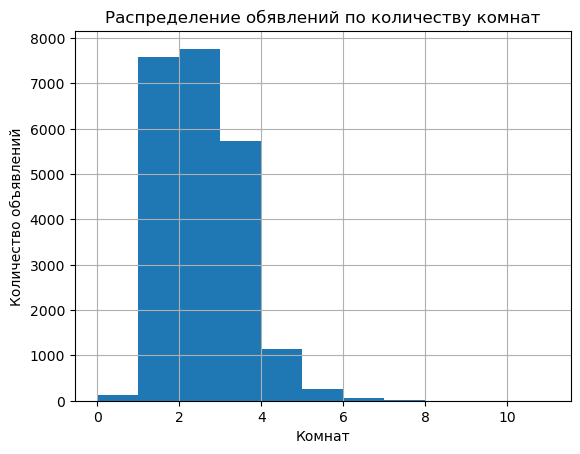

In [78]:
data['rooms'].hist(bins=11);
plt.title('Распределение обявлений по количеству комнат')
plt.ylabel('Количество объявлений')
plt.xlabel('Комнат')
plt.show()

5 и более комнат в 346 объявлениях - такую маленькую выборку можно совсем отбросить

В 117 объявлениях указано 0 комнат. Посмотрим внимательнее другие их характеристики квартир из этих обявлений

In [79]:
data[data['rooms'] == 0][['total_area', 'living_area', 'kitchen_area', 'floor']].describe().T

,count,mean,std,min,25%,50%,75%,max
total_area,117.0,30.543419,9.575484,25.2,27.0,28.0,30.5,98.4
living_area,117.0,19.137265,9.122022,-1.0,17.0,18.6,20.5,68.0
kitchen_area,117.0,-1.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0
floor,117.0,8.247863,5.852948,1.0,4.0,7.0,12.0,25.0


Средняя общая площадь около 30 квм, в них нет кухонь. Похоже это "студии". Отбрасывать их не стоит, хотя таких объявлений и мало мало

Оставляем только объявления с квартирами до 4 квартир включительно

In [80]:
data = data[data['rooms'] <= 4]

In [81]:
data.groupby('rooms')['rooms'].count()

rooms
0     117
1    7574
2    7763
3    5734
4    1131
Name: rooms, dtype: int64

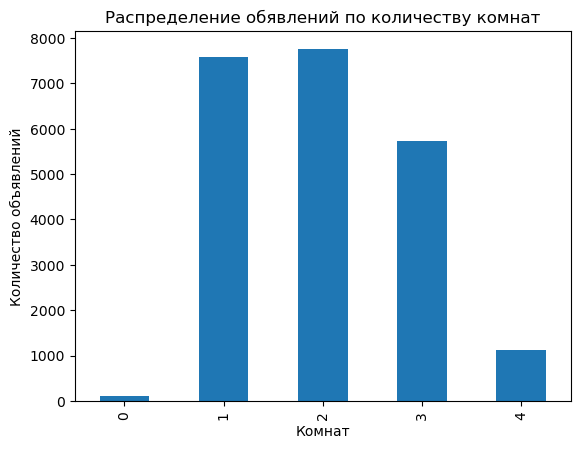

In [82]:
data.groupby('rooms')['rooms'].count().plot(kind='bar', x='rooms', y='count');
plt.title('Распределение обявлений по количеству комнат')
plt.ylabel('Количество объявлений')
plt.xlabel('Комнат')
plt.show()

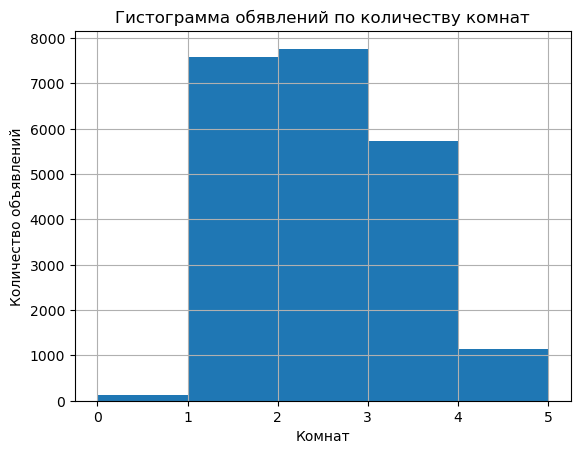

In [83]:
data['rooms'].hist(bins=[0, 1, 2, 3, 4, 5]);
plt.title('Гистограмма обявлений по количеству комнат')
plt.ylabel('Количество объявлений')
plt.xlabel('Комнат')
plt.show()

Оставили в датасете квартиры-студии и квартиры до 4 комнат включительно. Среди них больше всего 1-2-х комнатных квартир. 

### Итоговая цена объекта (колонка last_price)

In [84]:
data['last_price'].describe()

count    2.231900e+04
mean     5.883829e+06
std      5.915092e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.600000e+06
75%      6.580000e+06
max      3.300000e+08
Name: last_price, dtype: float64

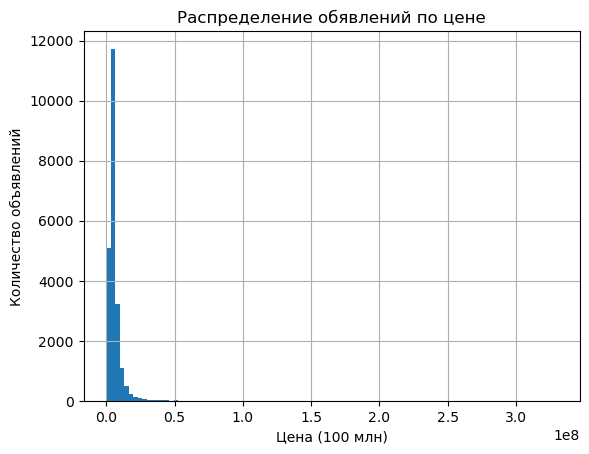

In [85]:
data['last_price'].hist(bins=100);
plt.title('Распределение обявлений по цене')
plt.ylabel('Количество объявлений')
plt.xlabel('Цена (100 млн)')
plt.show()

Распредение цен явно имеет большой "хвост", обусловленнй выбросами значений

По гистограмме видно, что подавлящее большинство квартир стоит менее 50 млн. рублей. Свыше этой суммы можно принять за выброс. Оценим границу выброса точнее:

In [86]:
for d in [50000000, 30000000, 20000000, 15000000, 10000000]:
    c = data[data['last_price'] > d]['last_price'].count()
    print('Квартир дороже', round(d/1000000), ' млн. - ', c, ' %', round(100 * c / datarows,2))

Квартир дороже 50  млн. -  39  % 0.16
Квартир дороже 30  млн. -  144  % 0.61
Квартир дороже 20  млн. -  426  % 1.8
Квартир дороже 15  млн. -  821  % 3.46
Квартир дороже 10  млн. -  2158  % 9.11


 Или через процентиль 98%:

In [87]:
np.quantile(data.last_price, 0.98)

19900000.0

Предлагаю убрать из датасета квартиры свыше 20 млн. рублей.

Также видим, что в данных есть квартиры с очень низкой ценой. Оценим сколько квратир продавалось ниже 1 млню рублей.

In [88]:
data[data['last_price'] < 1000000].sort_values(by='last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_1m,week_day,month,year,to_cityсenter,floor_type,t_k,t_l,living_area_new,kitchen_area_new
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,111.83,2,3,2019,9.0,последний,0.371560,0.293578,32.000,40.50
14911,5,430000.0,54.0,2018-06-26,2,2.65,3.0,-1.0,3,False,...,7962.96,1,6,2018,NaN,последний,-0.018519,-0.018519,29.700,8.64
17456,7,430000.0,30.4,2019-04-22,1,2.65,2.0,16.0,1,False,...,14144.74,0,4,2019,NaN,первый,0.197368,0.526316,16.000,6.00
16274,18,440000.0,40.0,2018-07-10,1,2.65,5.0,-1.0,1,False,...,11000.00,1,7,2018,NaN,первый,-0.025000,-0.025000,22.000,6.40
9581,7,450000.0,43.4,2018-08-31,2,2.65,5.0,30.3,3,False,...,10368.66,4,8,2018,NaN,другой,0.126728,0.698157,30.300,5.50
17676,0,450000.0,36.5,2018-02-01,1,2.65,5.0,17.3,4,False,...,12328.77,3,2,2018,NaN,другой,0.232877,0.473973,17.300,8.50
5698,7,450000.0,42.0,2017-07-31,2,2.65,1.0,23.0,1,False,...,10714.29,0,7,2017,NaN,последний,0.138095,0.547619,23.000,5.80
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,-1.0,1,False,...,11688.31,2,7,2018,NaN,первый,-0.025974,-0.025974,21.175,6.16
21912,0,470000.0,37.0,2018-02-18,1,2.65,3.0,-1.0,3,False,...,12702.70,6,2,2018,NaN,последний,-0.027027,-0.027027,20.350,5.92
23484,11,470000.0,44.5,2018-07-02,2,2.65,2.0,28.0,2,False,...,10561.80,0,7,2018,NaN,последний,0.168539,0.629213,28.000,7.50


У одной квартиры указана цена в 12 тысяч рублей. Явная ошибка в данных, ее можно откинуть. Без нее нижняя граница цены 430 тысяч рублей

In [89]:
data = data[(data['last_price'] < 20000000) & (data['last_price'] > 400000)] 

In [90]:
data['last_price'].describe()

count    2.188100e+04
mean     5.346810e+06
std      3.070064e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.550000e+06
75%      6.400000e+06
max      1.999900e+07
Name: last_price, dtype: float64

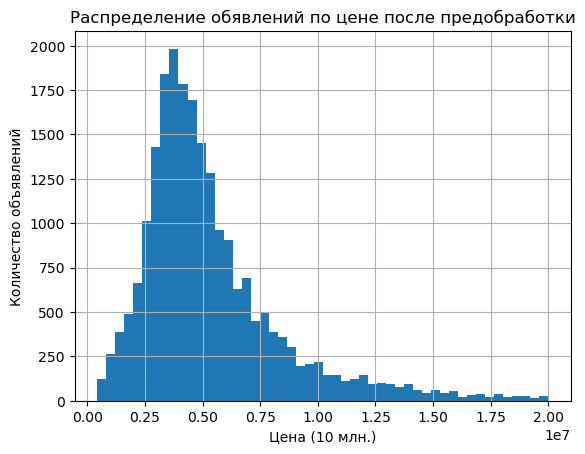

In [91]:
data['last_price'].hist(bins=50);
plt.title('Распределение обявлений по цене после предобработки')
plt.ylabel('Количество объявлений')
plt.xlabel('Цена (10 млн.)')
plt.show()

После обработки выбросов, распределение цен на крвартиры имеет близкое к нормальному виду форму, без "хвостов"

### Пропуски в колонках parks_nearest, ponds_nearest и cityCenters_nearest

Cкорее всего, пропуски в этой колонке обусловлены работой алгоритмом Яндекса, который не смог вычислить растояния до парка, водоема или центра. Както их восполнить нельзя.

In [92]:
data['parks_nearest'].isna().sum()

14729

In [93]:
data['ponds_nearest'].isna().sum()

13766

В половине данных нет расстояние до ближайего парка и водоема.

In [94]:
data['cityCenters_nearest'].isna().sum()

5214

В 20% данных нет расстояние до центра населенного пункта

Примечательно, что это пропуски для одних и тех же населенных пунктов.

In [95]:
for i in ['cityCenters_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest']:
    print ('Топ мест для которых есть пропуски в колонке', i)
    print(data[data[i].isna()].groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head())
    print ()

Топ мест для которых есть пропуски в колонке cityCenters_nearest
locality_name
Мурино        528
Кудрово       420
Всеволожск    383
Гатчина       294
Выборг        226
Name: locality_name, dtype: int64

Топ мест для которых есть пропуски в колонке parks_around3000
locality_name
Мурино        528
Кудрово       420
Всеволожск    383
Гатчина       294
Выборг        226
Name: locality_name, dtype: int64

Топ мест для которых есть пропуски в колонке ponds_around3000
locality_name
Мурино        528
Кудрово       420
Всеволожск    383
Гатчина       294
Выборг        226
Name: locality_name, dtype: int64

Топ мест для которых есть пропуски в колонке parks_nearest
locality_name
Санкт-Петербург    7905
Мурино              530
Кудрово             420
Шушары              418
Всеволожск          383
Name: locality_name, dtype: int64

Топ мест для которых есть пропуски в колонке ponds_nearest
locality_name
Санкт-Петербург    7258
Мурино              528
Кудрово             420
Всеволожск          3

Возможно, непосредсвтенно на административной территории Мурино или Кудрово просто нет парков / водоемов, как и общепринятого "центра города".

### Промежуточный вывод перед аналиизом данных

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21881 entries, 0 to 23697
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21881 non-null  int64         
 1   last_price            21881 non-null  float64       
 2   total_area            21881 non-null  float64       
 3   first_day_exposition  21881 non-null  datetime64[ns]
 4   rooms                 21881 non-null  int64         
 5   ceiling_height        21881 non-null  float64       
 6   floors_total          21810 non-null  float64       
 7   living_area           21881 non-null  float64       
 8   floor                 21881 non-null  int64         
 9   is_apartment          21881 non-null  bool          
 10  studio                21881 non-null  bool          
 11  open_plan             21881 non-null  bool          
 12  kitchen_area          21881 non-null  float64       
 13  balcony              

In [97]:
datarows - len(data)

1818

В результате предобработки данным всего было отброшено менее 2 тысяч строк с некорректными или выбивающимися данными. Пропуски остались в колонках, которые сформированя алгоритмом Яндекса, а также в колоке этажности зданий. Корректно заполнить их нельзя. 

Пере дальнейшим анализом переназначим индексы в датасете

In [98]:
data.reset_index(drop=True);

In [99]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,...,days_exposition,price_1m,week_day,month,year,to_cityсenter,t_k,t_l,living_area_new,kitchen_area_new
count,21881.000000,2.188100e+04,21881.000000,21881,21881.000000,21881.000000,21810.000000,21881.000000,21881.000000,21881.000000,...,19068.000000,21881.000000,21881.000000,21881.000000,21881.000000,16667.000000,21881.000000,21881.000000,21881.000000,21881.000000
mean,9.807733,5.346810e+06,55.946481,2017-11-12 05:24:34.649239040,1.985970,2.679388,10.743145,29.397313,5.891961,8.900098,...,177.384466,94450.241020,2.573283,6.409122,2017.375531,14.612228,0.166803,0.518228,31.914838,9.748153
min,0.000000,4.300000e+05,25.070000,2014-11-27 00:00:00,0.000000,2.000000,1.000000,-1.000000,1.000000,-1.000000,...,1.000000,7962.960000,0.000000,1.000000,2014.000000,0.000000,-0.039888,-0.039761,13.000000,4.011200
25%,6.000000,3.400000e+06,40.000000,2017-05-17 00:00:00,1.000000,2.600000,5.000000,18.000000,2.000000,6.300000,...,44.000000,75581.400000,1.000000,3.000000,2017.000000,10.000000,0.123810,0.471338,19.000000,7.000000
50%,9.000000,4.550000e+06,51.000000,2017-12-13 00:00:00,2.000000,2.650000,9.000000,29.000000,4.000000,8.700000,...,93.000000,93851.130000,3.000000,6.000000,2017.000000,13.000000,0.163934,0.556098,30.000000,9.000000
75%,14.000000,6.400000e+06,66.900000,2018-08-27 00:00:00,3.000000,2.700000,16.000000,40.000000,8.000000,11.000000,...,226.000000,111801.240000,4.000000,10.000000,2018.000000,17.000000,0.222443,0.627451,40.700000,11.100000
max,50.000000,1.999900e+07,199.200000,2019-05-03 00:00:00,4.000000,4.000000,60.000000,125.000000,33.000000,56.200000,...,1580.000000,392354.120000,6.000000,12.000000,2019.000000,66.000000,0.400000,0.989315,125.000000,56.200000
std,5.630414,3.070064e+06,21.630396,NaN,0.894343,0.184597,6.592969,16.462903,4.880803,5.058705,...,215.691662,32265.349731,1.789758,3.491957,1.030239,8.509378,0.084864,0.183176,14.270951,4.149722


## Как быстро продавались квартиры

Оценим статистические метрики колонки days_exposition. Дни размещения объявлений имеют минимум 1 день, максимум - 1500 дней. Причем 75% всех значений этого параметра менее 226. Средняя - 177 дней, медиана - 93 дня.

In [100]:
data['days_exposition'].describe()

count    19068.000000
mean       177.384466
std        215.691662
min          1.000000
25%         44.000000
50%         93.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

Выведем гистограмму диапазона 0-226 дней, так как 75% всех значений лежат в этом диапазоне. 
На ней видно несколько пиковых значений

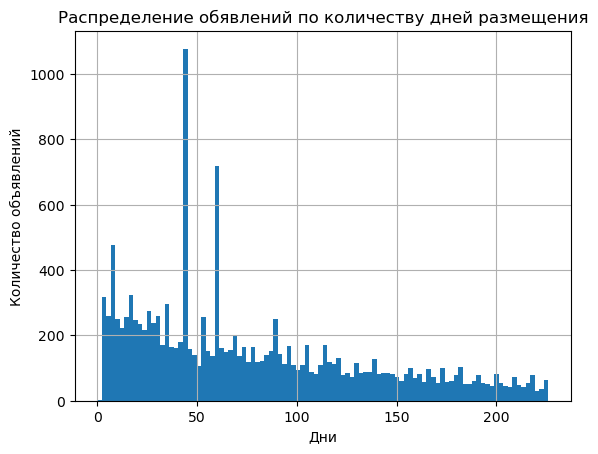

In [101]:
data['days_exposition'].hist(bins=100, range =(0, 226));
plt.title('Распределение обявлений по количеству дней размещения')
plt.ylabel('Количество объявлений')
plt.xlabel('Дни')
plt.show()

Выведем количество наиболее часто встречаюихся значений days_exposition

In [102]:
data[data['days_exposition'] < 226]\
    .groupby('days_exposition')['days_exposition']\
    .count()\
    .sort_values(ascending=False).head(10)

days_exposition
45.0    847
60.0    520
7.0     218
30.0    194
4.0     168
90.0    161
3.0     150
14.0    139
5.0     139
20.0    132
Name: days_exposition, dtype: int64

4 из 10 таких значений кратны 15. Это похоже на автоотключение объявлений по сроку. Была или нет совершена продажа - утверждать нельзя. Однако нормальным поведением пользователя должно быть снятие с публикации объявление вручную сразу после нахождения реального покупателя.

Оценим долю очень долго висевих объявлений.

In [103]:
for d in [1460, 1095, 730, 365, 180]:
    c = data[data['days_exposition'] > d]['last_price'].count()
    print('Квартир, которые продавались', d, 'дней -', c, '-', round(100 * c / datarows,2), '%')

Квартир, которые продавались 1460 дней - 10 - 0.04 %
Квартир, которые продавались 1095 дней - 142 - 0.6 %
Квартир, которые продавались 730 дней - 667 - 2.81 %
Квартир, которые продавались 365 дней - 2756 - 11.63 %
Квартир, которые продавались 180 дней - 5941 - 25.07 %


Объявлений, которые размещались больше двух лет - меньше 3%. Их можно не использовать в дальнейшем анализе.

Оценим статистиские метрики days_exposition без дней кратных 15. Возменем только объявления, которые размещались меньше  двух лет.

In [104]:
data[(data['days_exposition'] < 730) & ~(data['days_exposition'].isin([30, 45, 60, 90]))]['days_exposition'].describe()

count    17687.000000
mean       152.840222
std        156.209195
min          1.000000
25%         43.000000
50%         94.000000
75%        211.500000
max        729.000000
Name: days_exposition, dtype: float64

In [105]:
data.query('days_exposition < 730')['days_exposition'].describe()

count    18401.000000
mean       148.921526
std        154.407791
min          1.000000
25%         43.000000
50%         90.000000
75%        204.000000
max        729.000000
Name: days_exposition, dtype: float64

Cредний срок снятия объявлений в целом - 148 дней, а без учета кратных 15 дней - 152. Медиана - 90, а без учета кратных дней - 94 дня. Из этого можно сделать вывод, что кратные 15 дни снятия объявления слабо влюяют на статистику. Итоговые метрики лучше взять из датасета усеченного только границей в 730 дней - среднее 148, медиана 90. 

<u><b>Промежуточный вывод:</u></b>

Если покупатель на квартиру нашелся менее, чем 6 недель (1 квантиль - 43 дня) - можно считать это быстрой продажей. Если объявление висит уже 7 месяцев (3 квантиль - 204 дня), то это уже необычно долго.

## Факторы, которые влияют на стоимость объекта

Определим коэффициенты корреляции для стоисомти квартиры от данных в других колонках:
- общей площади
- жилой площади
- площади кухни
- количества комнат
- этажа, на котором расположена квартира (первый, последний, другой)
- даты размещения (день недели, месяц, год)

In [106]:
data[['last_price', \
      'total_area', \
      'living_area', 'living_area_new', \
      'kitchen_area', 'kitchen_area_new', \
      'rooms',  \
      'week_day', 'month', 'year']]\
    .corr()['last_price']

last_price          1.000000
total_area          0.764847
living_area         0.523848
living_area_new     0.651817
kitchen_area        0.472078
kitchen_area_new    0.609528
rooms               0.463864
week_day           -0.015411
month               0.009060
year               -0.022906
Name: last_price, dtype: float64

Коэффициент корреляци близкий к 1 говорит о сильной зависимости стоимости от общей площади. Как мы выяснили, жилая площади и площадь кухгни коррелирует с общей площадью, поэтому зависимость цены квартиры этих площадей также проследживается, хотя и слабее.
Цена мало зависит от количества комнат - Коэффициент корреляци ниже 0,5 
Цена практически не зависит от даты подачи заявления - коэффициент корреляци близкий к 0.

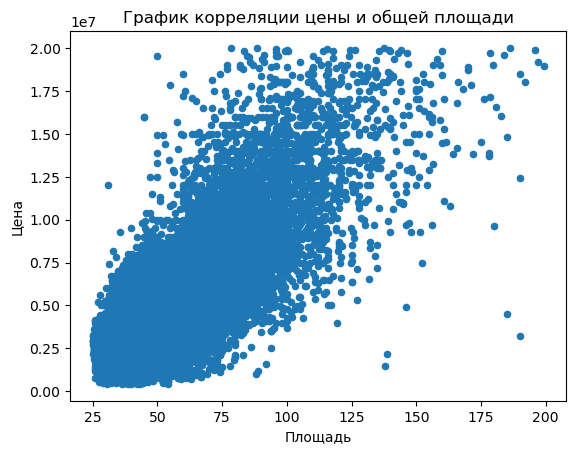

In [107]:
data.plot(x='total_area', y='last_price', kind='scatter');
plt.title('График корреляции цены и общей площади')
plt.ylabel('Цена')
plt.xlabel('Площадь')
plt.show()

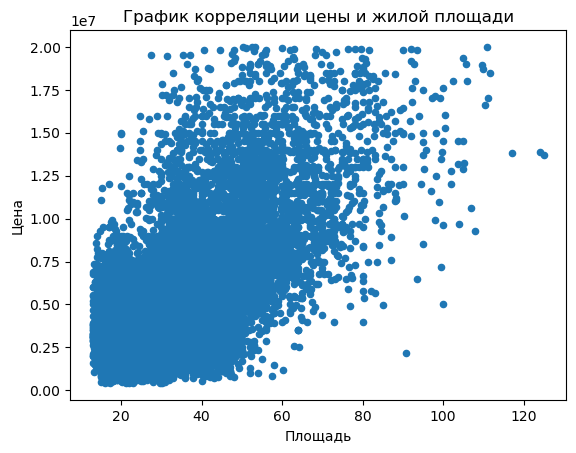

In [108]:
data.plot(x='living_area_new', y='last_price', kind='scatter');
plt.title('График корреляции цены и жилой площади')
plt.ylabel('Цена')
plt.xlabel('Площадь')
plt.show()

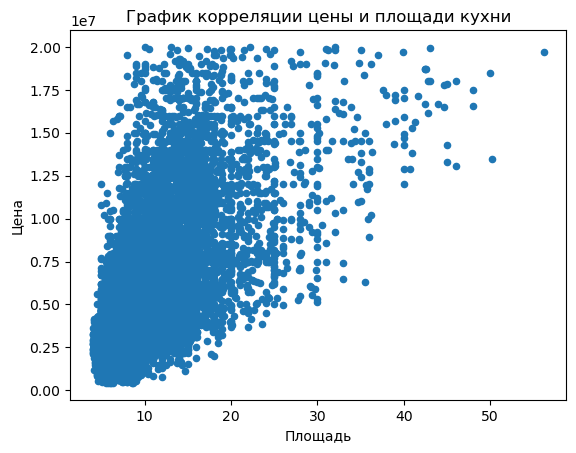

In [109]:
data.plot(x='kitchen_area_new', y='last_price', kind='scatter');
plt.title('График корреляции цены и площади кухни')
plt.ylabel('Цена')
plt.xlabel('Площадь')
plt.show()

Общая площадь квартиры прямо влияет на итоговую цену квартиры

### Влияние этажа на цену квартир

Оценим влияние типа этажа - первый, послений, другой на цену квартиры

In [110]:
data.groupby('floor_type')['last_price'].mean()

floor_type
другой       5.591472e+06
первый       4.324077e+06
последний    4.955902e+06
Name: last_price, dtype: float64

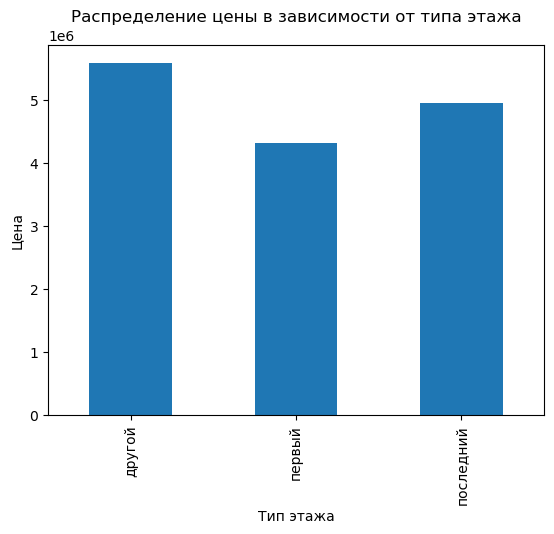

In [111]:
data.groupby('floor_type')['last_price'].mean().plot(kind='bar');
plt.title('Распределение цены в зависимости от типа этажа')
plt.ylabel('Цена')
plt.xlabel('Тип этажа')
plt.show()

Гистограмма показывает, что, скорее всего, крватиры на первом или последнем этажах будут стоит дешевле, чем на средних

###  Влияние даты размещения объявления на цену квартир

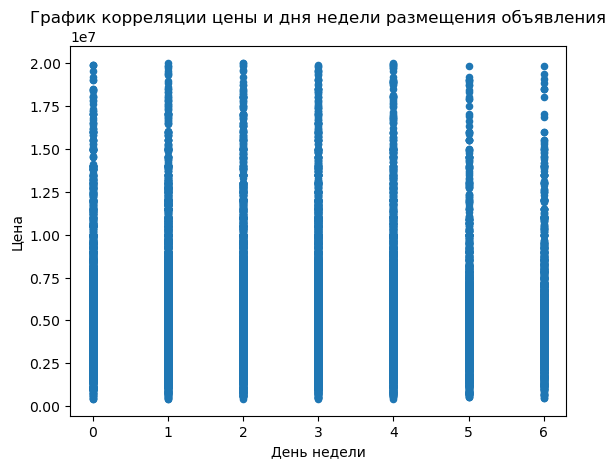

In [112]:
data.plot(x='week_day', y='last_price', kind='scatter');
plt.title('График корреляции цены и дня недели размещения объявления')
plt.ylabel('Цена')
plt.xlabel('День недели')
plt.show()

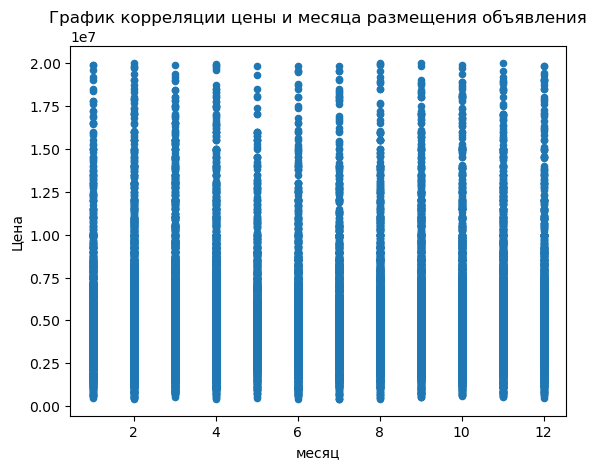

In [113]:
data.plot(x='month', y='last_price', kind='scatter');
plt.title('График корреляции цены и месяца размещения объявления')
plt.ylabel('Цена')
plt.xlabel('месяц')
plt.show()

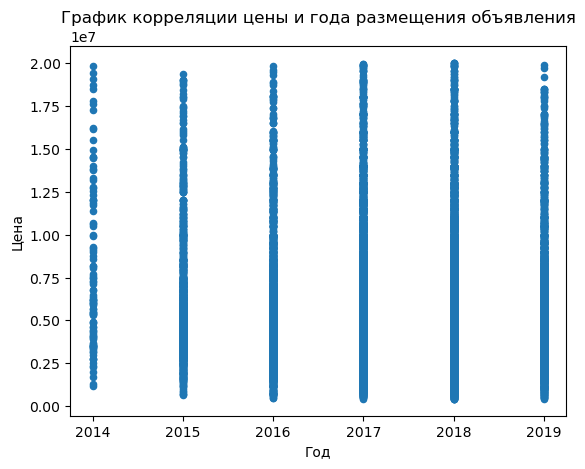

In [114]:
data.plot(x='year', y='last_price', kind='scatter');
plt.title('График корреляции цены и года размещения объявления')
plt.ylabel('Цена')
plt.xlabel('Год')
plt.show()

Зависимости цены квартир от дня недели, месяца или года размещения объявления - нет.

### Другие возможные факторы

Оценим влияние других оставшихся в датасете колонок на цену, вычислив коэффициент корреляции

In [115]:
data[['last_price', \
      'parks_nearest', \
      'ponds_nearest', \
      'airports_nearest', \
      'cityCenters_nearest', \
      'days_exposition'
      ]]\
    .corr()['last_price']

last_price             1.000000
parks_nearest          0.071672
ponds_nearest         -0.094800
airports_nearest      -0.027692
cityCenters_nearest   -0.346367
days_exposition        0.111877
Name: last_price, dtype: float64

In [116]:
data[['price_1m', \
      'parks_nearest', \
      'ponds_nearest', \
      'airports_nearest', \
      'cityCenters_nearest', \
      'days_exposition'
      ]]\
    .corr()['price_1m']

price_1m               1.000000
parks_nearest          0.097919
ponds_nearest         -0.076955
airports_nearest      -0.037296
cityCenters_nearest   -0.399999
days_exposition        0.011134
Name: price_1m, dtype: float64

Статистической зависимости цены квартир от других факторов не прослеживается

<u><b>Промежуточный вывод</b></u>

На итоговую цену квартир прежде всего влияют ее общая площадь и удаленность от центра города. Первый или последний этаж сделают квартиру дешевле. Другие параметры сладо влияют на цену.

## Cредняя цена 1 квм в 10 населённых пунктах с наибольшим числом объявлений

Составим список населенных пунктов, которые чаще всего указывалсь в объявлениях

In [117]:
citys = data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)
citys

locality_name
Санкт-Петербург    14302
Мурино               530
Кудрово              420
Шушары               418
Всеволожск           383
Пушкин               344
Колпино              332
Парголово            311
Гатчина              294
Выборг               226
Name: locality_name, dtype: int64

Определим среднюю стоимость 1 квм в пунктах с наибольшим числом объявлений

In [118]:
data.groupby('locality_name') \
    .agg({'price_1m': ['count', 'mean']}) \
    .sort_values(by=[('price_1m', 'count')], ascending=False) \
    .head(10)

price_1m               
                   count           mean
locality_name                          
Санкт-Петербург    14302  108364.312814
Мурино               530   85028.263170
Кудрово              420   94573.055167
Шушары               418   77677.906770
Всеволожск           383   67059.445091
Пушкин               344  101887.454070
Колпино              332   75403.749307
Парголово            311   89931.029486
Гатчина              294   68966.424490
Выборг               226   58088.988540

Еще один способ через цикл

In [119]:
top_city_price = pd.DataFrame([], columns=['city', 'count', 'price'])
for i in citys.index:
    
    top_city_price.loc[len(top_city_price.index)] = [\
         i, \
         data[data['locality_name'] == i]['locality_name'].count(), \
         round(data[data['locality_name'] == i]['price_1m'].mean(),2) \
        ]
top_city_price.sort_values(by='price', ascending=False)


,city,count,price
0,Санкт-Петербург,14302,108364.31
5,Пушкин,344,101887.45
2,Кудрово,420,94573.06
7,Парголово,311,89931.03
1,Мурино,530,85028.26
3,Шушары,418,77677.91
6,Колпино,332,75403.75
8,Гатчина,294,68966.42
4,Всеволожск,383,67059.45
9,Выборг,226,58088.99


<u><b>Промежуточный вывод</b></u>

Средня цена 1квм выше всего в  Санкт-Петербурге, Пушкине, Кудрово

## Cредняя цена 1 квм для каждого километра от центра Санкт-Петербурга

Оценим статистические метрики по цене квартир для Санкт-Петербурга. Минимум - 1,2 млн. рублей, максимум - почти 20 млн. рублей. Средняя - 6.3 млн. рублей, медиана - 5,3 млн. рублей. 

In [120]:
data[data['locality_name'] == 'Санкт-Петербург']['last_price'].describe()

count    1.430200e+04
mean     6.331908e+06
std      3.138931e+06
min      1.200000e+06
25%      4.180000e+06
50%      5.350000e+06
75%      7.500000e+06
max      1.999900e+07
Name: last_price, dtype: float64

Посчитаем среднюю цену, в зависимости от удаленности от центра города

In [121]:
data[data['locality_name'] == 'Санкт-Петербург'].groupby('to_cityсenter').agg({'last_price': ['count', 'mean']})

last_price              
                   count          mean
to_cityсenter                         
0.0                   12  9.248333e+06
1.0                  138  1.028870e+07
2.0                  214  9.607836e+06
3.0                  274  8.595165e+06
4.0                  533  8.977205e+06
5.0                  696  9.203413e+06
6.0                  464  8.448481e+06
7.0                  320  7.850035e+06
8.0                  531  7.802899e+06
9.0                  554  6.375749e+06
10.0                 677  5.977085e+06
11.0                1137  5.903618e+06
12.0                1553  5.716777e+06
13.0                1405  5.971167e+06
14.0                1238  5.553985e+06
15.0                1505  5.670678e+06
16.0                1219  5.265767e+06
17.0                 855  5.179006e+06
18.0                 251  4.918759e+06
19.0                 148  5.098928e+06
20.0                  46  6.073517e+06
21.0                 111  5.415832e+06
22.0                 200  5.374680e+06
23.0                  81  4.726765e+06
24.0                  26  3.854430e+06
25.0                  22  4.036591e+06
26.0                  38  4.314346e+06
27.0                   2  8.300000e+06
28.0                   7  5.026429e+06
29.0                   6  4.236667e+06

Построим график зависиости цены квартиру от удаленности от центра города

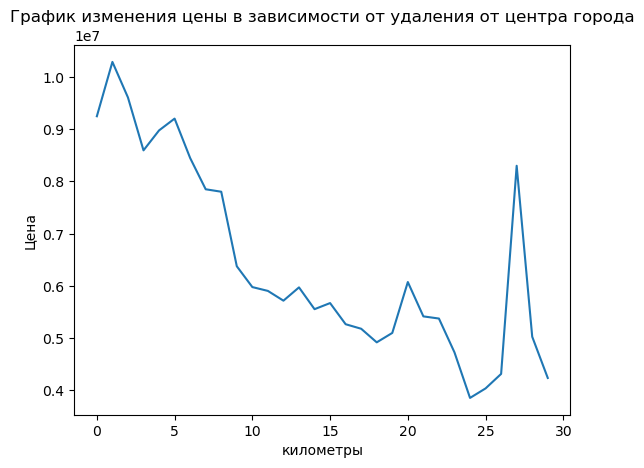

In [122]:
data[data['locality_name'] == 'Санкт-Петербург'].groupby('to_cityсenter')['last_price'].mean().plot();
plt.title('График изменения цены в зависимости от удаления от центра города')
plt.ylabel('Цена')
plt.xlabel('километры')
plt.show()

Оценка пика на 27 км:

In [123]:
data[(data['locality_name'] == 'Санкт-Петербург') & (data['to_cityсenter'] == 27)].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_1m,week_day,month,year,to_cityсenter,floor_type,t_k,t_l,living_area_new,kitchen_area_new
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,...,193918.92,1,11,2017,27.0,другой,0.337838,0.405405,30.0,25.0
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2.0,16.5,2,False,...,70312.50,1,2,2018,27.0,последний,0.218750,0.515625,16.5,7.0


<u><b>Промежуточный вывод</b></u>

Цена 1 квм сильно зависит от расстояние до центра Санкт-Петербугра и снижается к окраинам
Скачок на 19-22 км от центра города, скорее всего, связан с попаданием в этот интервал объявлений из Пушкина, в которых авторы указали свой населенный пункт Санкт-Петербург.
Пик на 27 км связан с тем, что на этот км приглось всего 2 объявления, и одно из них с высокой ценой.

## Общий вывод

На анализ был представле датасет объявлений по продаже квартир в Санкт-Петербурге c ноября 2014 года по май 2019 года. Общее количество строк - 23699.

В ходе предобработки были заполнены пропуски данных, где это было возможно. Также были удалены слишком выбивающиеся из общей статистики данные. Количество удаленных строк по отдельным колонкам - не больше 2% от выборки. В итоге в датасете осталось 21881 строк. 

Анализ этих данных показал, что цены на квартиры сильнее всего зависият от площади и удаленности от центра города. Цены за 1 квм почти линейно снижается с увеличением растояния от центра Сантк-Петербурга. Но при этом могут быть локальные подъемы цены в границах пригорода или отдаленного района города. Средня цена 1 квм выше всего в Санкт-Петербурге, Пушкине, Кудрово. Кроме этого, первый или последний этаж наверянка сделуют квартиру дешевле.

Остальные параметры имеют слабое влияние на цену квартиры, либо вообще никак не влияют. 

Обычно квартиры продаются за 90 дней (медианное значение). Если покупатель на квартиру нашелся менее, чем 6 недель - можно считать это быстрой продажей. Если объявление висит уже 7 месяцев и более, то это уже необычно долго.
